In [1]:
# load packages
%matplotlib inline
%cd ..
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pandas as pd
import os
from pynwb import NWBFile, TimeSeries, NWBHDF5IO
from scipy.io import loadmat
from scipy.stats import zscore

from open_ephys.analysis import Session
from pathlib import Path
import glob


%matplotlib widget
import spikeinterface as si
import xarray as xr
import json
import seaborn as sns
from PyPDF2 import PdfMerger
from aind_ephys_utils import align 
from myFunctions import*
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import re

import spikeinterface.postprocessing as spost
import spikeinterface.qualitymetrics as sqm
import spikeinterface.curation as scur

# recompute qc
from spikeinterface.qualitymetrics.misc_metrics import isi_violations, presence_ratio, amplitude_cutoff


/root/capsule/code


In [2]:
# set parameters
curationName = 'ZhixiaoSu'
sessionID = '716325_2024-05-31_10-31-14'


In [3]:
# find raw data
data_dir = "/root/capsule/data/"
data_folder = Path("/data")
ecephys_folders = [
    p
    for p in data_folder.iterdir()
    if p.is_dir() and ("ecephys" in p.name or "behavior" in p.name) and ("sorted" not in p.name and "nwb" not in p.name and "curated" not in p.name) and (sessionID in p.name)
]

ecephys_folder = ecephys_folders[0]
ecephys_compressed_folder = ecephys_folder / "ecephys_compressed"
ecephys_clipped_folder = ecephys_folder / "ecephys_clipped"

# find sorted data
sorted_folders = [
    p for p in data_folder.iterdir() if p.is_dir() and "sorted" in p.name and "spikesorted" not in p.name and sessionID in p.name
]
sorted_folder = sorted_folders[0]

postprocessed_folder = sorted_folder / "postprocessed"
curated_folder = sorted_folder / "curated"
spikesorted_folder = sorted_folder / "spikesorted"

# nwb file
nwb_folder = f"{data_dir}{sessionID}_experiment1_recording1"
nwb_file = f"{sessionID}_experiment1_recording1.nwb"

# stream name: 
stream_names =  [p.name for p in postprocessed_folder.iterdir() if p.is_dir() and "post" not in p.name]
stream_name = stream_names[0]

# find manual curation data
manualCuration_dir = [
    p for p in data_folder.iterdir() if p.is_dir() and "sorted" not in p.name and "spikesorted" not in p.name and sessionID in p.name and "curated" in p.name
]

manualCuration_dir = manualCuration_dir[0]

curation_jsons = []
for root, dirs, files in os.walk(manualCuration_dir):
    if len(curation_jsons)>0:
        break
    for file in files:
        if len(curation_jsons)>0:
            break
        if file.startswith("curation") and file.endswith(f"curation.json"):
            curation_jsons.append(os.path.join(root, file))

curation_json = curation_jsons[0]

assert curated_folder.is_dir(), f"Curated folder {curated_folder} does not exist"
assert spikesorted_folder.is_dir(), f"Spikesorted folder {spikesorted_folder} does not exist"
assert manualCuration_dir.is_dir(), f"Manual curation folder {spikesorted_folder} does not exist"

print(f'Raw data: {ecephys_folder}')
print(f'Sorted: {sorted_folder}')
print(f'Curation: {curation_json}')

Raw data: /data/behavior_716325_2024-05-31_10-31-14
Sorted: /data/behavior_716325_2024-05-31_10-31-14_sorted-opto-ZS_2024-06-05_03-54-32
Curation: /data/behavior_716325_2024-05-31_10-31-14_curated_2024-06-08_01-06-46/experiment1_Record Node 104#Neuropix-PXI-100.ProbeA_recording1/kilosort2_5/curation.json


In [4]:
# load ephys recordings
directory = Path(f"{data_dir}behavior_{sessionID}")

session = Session(ecephys_clipped_folder)
recording = session.recordnodes[0].recordings[0]

# parse barcode
nidaq_node_id = 103
harp_clock = recording.events[(recording.events.processor_id == nidaq_node_id) &
                 (recording.events.line == 4)]

# gain barcode time

splits = np.where(np.diff(harp_clock.timestamp) > 0.5)[0]
print(f'Total number of barcodes: {len(splits)}')

splits = np.where(np.diff(harp_clock.timestamp) > 0.5)[0]
first_barcode_ts = harp_clock.iloc[splits[0]+1:splits[1]+1].iloc[0].timestamp
last_barcode_ts = harp_clock.iloc[splits[-2]+1:splits[-1]+1].iloc[0].timestamp
sample_numbers, states = get_barcode(harp_clock, 0)
first_barcode_harp_time = convert_barcode_to_time(sample_numbers, states)
sample_numbers, states = get_barcode(harp_clock, -2)
last_barcode_harp_time = convert_barcode_to_time(sample_numbers, states)
print(f'Total seconds on Harp clock: {last_barcode_harp_time - first_barcode_harp_time}')
print(f'Total seconds on Open Ephys clock: {last_barcode_ts - first_barcode_ts}')

Total number of barcodes: 7024
Total seconds on Harp clock: 7022
Total seconds on Open Ephys clock: 7022.660466666666


In [28]:
# re-scale probe time
probe_timestamps = recording.continuous[0].timestamps
probe_timestamps_scaled = rescale_times(probe_timestamps, 
                          first_barcode_harp_time, 
                          last_barcode_harp_time,
                          first_barcode_ts,
                          last_barcode_ts)
# merge units and rescale time                         
sorting = si.load_extractor(curated_folder/ stream_name)
# merge units
sorting_merged = scur.apply_sortingview_curation(sorting, uri_or_json=curation_json)
unit_ids = sorting_merged.get_unit_ids()
# no merge units
sorting_merged = sorting
unit_ids = sorting_merged.get_unit_ids()


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 31, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 47, 48, 49, 51, 52, 53, 54, 55, 56, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 129, 133, 134, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 

In [29]:
sortingview_curation_dict = json.load(open(curation_json))
merge_groups = sortingview_curation_dict['mergeGroups']
# get merged ID
unit_ids_ori = sorting.unit_ids
mergedUnits = np.setdiff1d(unit_ids, unit_ids_ori)
unit_ids_merge = [None]*len(unit_ids)
merge_count = 0

# give merge name to all units
for unit_ind, unit_id in enumerate(unit_ids):
    if unit_id in mergedUnits:
        unit_ids_merge[unit_ind] = merge_groups[merge_count]
        merge_count += 1
        unit_ids_merge[unit_ind] = [unit_id]
    else:
        unit_ids_merge[unit_ind] = [unit_id]

if merge_count == len(merge_groups):
    print(f'Renamed all {len(merge_groups)} units.')
else:
    print(f'Renamed {merge_count} out of {len(merge_groups)} units.')


# regenerate unit times: 
timestamps = []
for unit_id in unit_ids:
    spike_time = np.squeeze(probe_timestamps_scaled[sorting_merged.get_unit_spike_train(unit_id)])
    # print(f'{unit_id} number of spikes {len(spike_time)}')
    timestamps.append(spike_time)

Renamed 0 out of 38 units.


In [30]:
# cut off drifty parts: start and end
# load task
io = NWBHDF5IO(nwb_folder + '/' + nwb_file, mode='r')
nwb = io.read()
# units = nwb.units.to_dataframe()
# unitIDs = units['ks_unit_id'].astype(int)
# define cut time
sessionStartCut = 1000 # in second
sessionEndCut = 0 # in second
# cutWin = [sessionStart, sessionEnd]
timestampsCut = [timestampsCurr[(timestampsCurr>=first_barcode_harp_time+sessionStartCut) & (timestampsCurr<=last_barcode_harp_time-sessionEndCut)] for timestampsCurr in timestamps]
print(f'Cut from {first_barcode_harp_time+sessionStartCut} to {last_barcode_harp_time-sessionEndCut}') 
# load behavior
tblTrials = nwb.trials.to_dataframe()
start = np.where(tblTrials['delay_start_time']>=first_barcode_harp_time+sessionStartCut)[0][0]
stop = np.where(tblTrials['stop_time']<=last_barcode_harp_time-sessionEndCut)[0][-1]
tblTrialsCut = tblTrials.iloc[start:(stop+1)].copy()
print(f'Cut from trial No. {tblTrialsCut.index[0]} to {tblTrialsCut.index[-1]} from a session of {len(tblTrials)} trials') 

trialTblChoice = makeSessionDF(nwb, [start, stop])


Cut from 3893431 to 3899453
Cut from trial No. 38 to 585 from a session of 586 trials


In [31]:
# recompute quality metrics
# set parameters
sample_rate = 30000
bin_duration_s=60.0
mean_fr_ratio_thresh = 0.01
# prepare inputs
recLength = -(first_barcode_harp_time+sessionStartCut) + (last_barcode_harp_time-sessionEndCut)
bin_edges = np.arange(first_barcode_harp_time+sessionStartCut, last_barcode_harp_time-sessionEndCut, bin_duration_s)


def simpleQm(unit_ids, timestampsCut, recLength, sample_rate, bin_duration_s, mean_fr_ratio_thresh, bin_edges):

    isi_violations_ratio = [None]*len(timestampsCut)
    isi_violations_rate = [None]*len(timestampsCut)
    isi_violations_count = [None]*len(timestampsCut)
    presence_ratio_qc = [None]*len(timestampsCut)
    firing_rate = [None]*len(timestampsCut)

    for unitInd, timestampsCutCurr in enumerate(timestampsCut):
        # isi_v
        isi_violations_ratio[unitInd], isi_violations_rate[unitInd], isi_violations_count[unitInd] = isi_violations([timestampsCutCurr], recLength, isi_threshold_s=0.0015, min_isi_s=1/sample_rate)
        # presence ratio
        unit_fr = len(timestampsCutCurr)/recLength
        bin_n_spikes_thres = np.floor(unit_fr * bin_duration_s * mean_fr_ratio_thresh)
        presence_ratio_qc[unitInd] = presence_ratio(timestampsCutCurr, recLength, bin_edges=bin_edges, bin_n_spikes_thres=bin_n_spikes_thres)
        # firing rate
        firing_rate[unitInd] = unit_fr
    qm = pd.DataFrame({
                    'unit_id': unit_ids,
                    'isi_violations_ratio': isi_violations_ratio,
                    'presence_ratio': presence_ratio_qc,
                    'firing_rate': firing_rate})
    return qm
qm = simpleQm(unit_ids, timestampsCut, recLength, sample_rate, bin_duration_s, mean_fr_ratio_thresh, bin_edges)

In [43]:
sample_rate = 30000
recLength = -(first_barcode_harp_time+sessionStartCut) + (last_barcode_harp_time-sessionEndCut)
mean_fr_ratio_thresh = 0

bin_durations = np.arange(2, 60, 2)

pr_mat = []
for bin_duration in bin_durations:
    bin_edges = np.arange(first_barcode_harp_time+sessionStartCut, last_barcode_harp_time-sessionEndCut, bin_duration)
    qm = simpleQm(unit_ids, timestampsCut, recLength, sample_rate, bin_duration, mean_fr_ratio_thresh, bin_edges)
    pr_mat.append(qm['presence_ratio'])
    
pr_mat = np.array(pr_mat)
np.shape(pr_mat)


(29, 359)

Text(0.5, 1.0, '0')

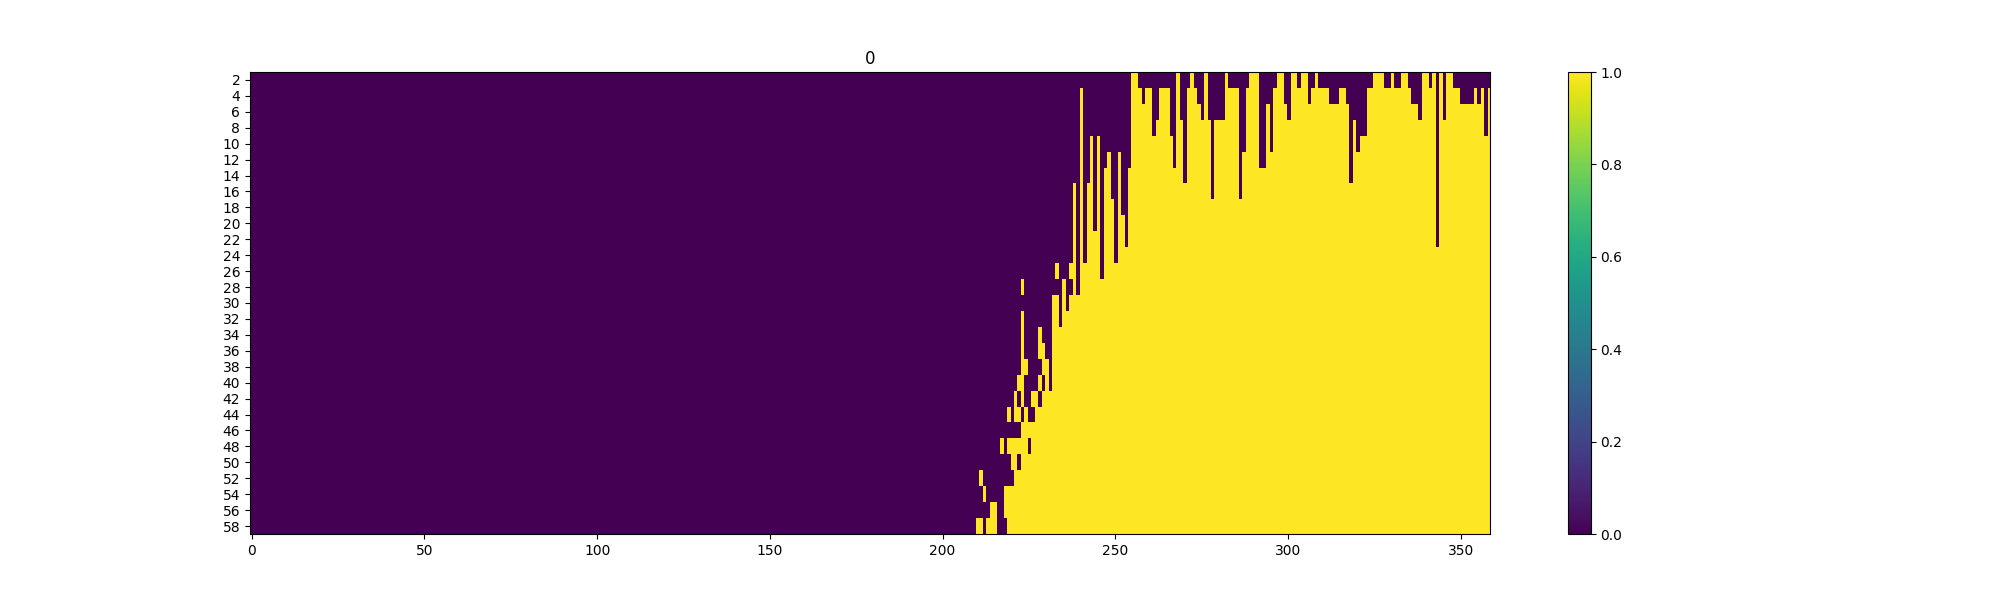

In [44]:
plt.figure(figsize=(20, 6))  # Width: 8 inches, Height: 6 inches
seq = np.argsort(np.mean(pr_mat, 0))
seq = np.argsort(np.mean(pr_mat[-10:,:], 0))
plt.imshow(pr_mat[:,seq]>0.95,aspect='auto');
plt.colorbar();
y_labels = bin_durations.tolist()
plt.yticks(ticks=np.arange(len(y_labels)), labels=y_labels);
plt.title(mean_fr_ratio_thresh)

In [33]:
#%% read manual curation results.
sortingview_curation_dict = json.load(open(curation_json))
unitIDs = unit_ids
# # set default to false
merge = np.array([False]*len(unitIDs))
# commented out unit merging because merged units are eliminated in merging process
# if 'mergeGroups' in sortingview_curation_dict.keys():
#     merge_groups = sortingview_curation_dict["mergeGroups"]
#     # get units in merge groups
#     merge_units = [unit for merge_group in merge_groups for unit in merge_group]
#     merge_units = np.sort(np.unique(merge_units))
#     mergeInds = [index for index, value in enumerate(unitIDs) if value in merge_units]
#     merge[np.array(mergeInds)] = True
# merged units
merged = np.isin(unitIDs, mergedUnits)

# SUA units
SUAunits = [key for key, value in sortingview_curation_dict["labelsByUnit"].items() if ('SUA' in value)|('accept' in value)]
SUAunits = np.array(SUAunits).astype(int)
SUAInds = [index for index, value in enumerate(unitIDs) if value in SUAunits]
SUA = np.array([False]*len(unitIDs))
SUA[np.array(SUAInds)] = True
# MUA, noise and reject
noiseUnits = [key for key, value in sortingview_curation_dict["labelsByUnit"].items() if ('MUA' in value)|('noise' in value)|('artifact' in value)|('reject' in value)]
noiseUnits = np.array(noiseUnits).astype(int)
noiseInds = [index for index, value in enumerate(unitIDs) if value in noiseUnits]
noise = np.array([False]*len(unitIDs))
noise[np.array(noiseInds)] = True
artifact = np.array([False]*len(noise))
# load artifact
# artifactPath = Path(f"{data_dir}artifactFilter/{sessionID}_artifact.npy")
# artifact = np.load(artifactPath)

In [34]:
# combine manual curation and artifact
qm['merge'] = merge
qm['merged'] = merged
qm['SUA'] = SUA
qm['noise'] = noise
qm['artifact'] = artifact
qm['default_qc'] = sorting_merged.get_property('default_qc')

manual = (qm['default_qc']) & (~qm['noise'])|(qm['default_qc']) & (qm['SUA'] & (~qm['artifact']))|(qm['merged'])
qcPass = (qm["presence_ratio"]>0.9) & (qm["isi_violations_ratio"]<0.1) & (qm['firing_rate']>0.2) & (manual)
print(f"{np.sum(qcPass)} out of {len(unitIDs)} pass qc")

42 out of 359 pass qc


In [35]:
# plot and save all units with append method
sessionFolder = Path(f'/root/capsule/scratch/{sessionID}')
if not Path.exists(sessionFolder):
    print('Creating sessionFolder')
    os.mkdir(sessionFolder)
# plot and save
xarrayFolder = Path(f"{sessionFolder}/rasters")
if not Path.exists(xarrayFolder):
    print('Creating rasterFolder')
    os.mkdir(xarrayFolder)

Creating rasterFolder


In [36]:
tblTrials = tblTrialsCut.copy()
# responseInds
responseInds = tblTrials['animal_response']!=2

# response time
trialStarts = tblTrials.loc[tblTrials['animal_response']!=2, 'goCue_start_time'].values
responseTimes = tblTrials.loc[responseInds, 'reward_outcome_time'].values

# outcome                                       
leftRewards = tblTrials.loc[responseInds, 'rewarded_historyL'].values
rightRewards = tblTrials.loc[responseInds, 'rewarded_historyR'].values
outcomes = leftRewards | rightRewards
outcomePrev = np.concatenate((np.full((1), np.nan), outcomes[:-1]))

# choices
choices = tblTrials.loc[responseInds, 'animal_response'] == 1
choicesPrev = np.concatenate((np.full((1), np.nan), choices[:-1]))
# laser
laserChoice = tblTrials.loc[responseInds, 'laser_on_trial'] == 1
laser = tblTrials['laser_on_trial'] == 1
laserPrev = np.concatenate((np.full((1), np.nan), laserChoice[:-1]))
trialData = trialTblChoice


In [37]:
# make xarray
# for psth
binSize = 0.2 # in second
stepSize = 0.05 # in second
bin_edges = np.arange(-2, 3, stepSize)
time_domain_callback = None
alignTime = responseTimes

domain = build_time_window_domain(
    bin_edges,
    alignTime,
    callback=time_domain_callback)

time, counts = build_spike_histogram_overlap(
    domain,
    binSize,
    timestampsCut,
)

time = bin_edges[:-1] + 0.5*binSize
tiled_data = 1/binSize * counts

trialInds = np.array(range(len(alignTime)))

spike_toResponse = xr.DataArray(
    name='spike_counts',
    data=tiled_data,
    dims=['trialInd',
          'trialTime',
          'unit_id'],
    coords={
        'trialInd': trialInds,
        'trialTime': time,
        'unit_id': np.array(range(len(timestampsCut)))
    }
)

# for LM
binSizeLM = 0.5
stepSizeLM = 0.2
bin_edgesLM = np.arange(-2, 3, stepSizeLM)

domain = build_time_window_domain(
    bin_edgesLM,
    alignTime,
    callback=time_domain_callback)
dtype = None

timeLM, countsLM = build_spike_histogram_overlap(
    domain,
    binSizeLM,
    timestampsCut,
)
timeLM = bin_edgesLM[:-1] + 0.5*binSizeLM
tiled_dataLM = 1/binSizeLM * countsLM

# for baseline
binSizeBl = 1
stepSizeBl = 0.2
bin_edgesBl = np.arange(-4, 0, stepSizeBl)

domain = build_time_window_domain(
    bin_edgesBl,
    alignTime,
    callback=time_domain_callback)
dtype = None

timeBl, countsBl = build_spike_histogram_overlap(
    domain,
    binSizeBl,
    timestampsCut,
)

timeBl= bin_edgesBl[:-1] + 0.5*binSizeBl
tiled_dataBl = 1/binSizeBl * countsBl

spike_toResponseBl = xr.DataArray(
    name='spike_counts',
    data=tiled_dataBl,
    dims=['trialInd',
          'trialTime',
          'unit_id'],
    coords={
        'trialInd': trialInds,
        'trialTime': timeBl,
        'unit_id': np.array(range(len(timestampsCut)))
    }
)


In [38]:
def plot_unit(unitInd, unit_label, align_time, savepath):
    plt.clf()
    currArray = spike_toResponse.sel(unit_id = unitInd)
    currArrayLM = np.squeeze(tiled_dataLM[:,:,unitInd])
    currArrayBl = spike_toResponseBl.sel(unit_id = unitInd)
    currSpikes = timestampsCut[unitInd]
    fig = plt.figure(figsize=(30, 15))
    gs = gridspec.GridSpec(2, 5, width_ratios=[1,1,1,1,1], height_ratios=[4, 1])

    # from start to end
    ax = fig.add_subplot(gs[0, 0])  
    df = align.to_events(currSpikes, align_time, (tb, tf), return_df=True)
    ax.scatter(df.time, df.event_index, c='k', marker= '|', s=1)
    ax.set_xlim(tb, tf)
    ax.set_ylabel('Trial number', fontsize = fs)
    ax.tick_params(axis='both', which='major', labelsize=fs)
    plt.plot([0,0],[0,df.event_index.max()],'r')
    plt.suptitle(f'Unit{str(unit_label)}', fontsize = 20)

    # # waveform
    # ax = fig.add_subplot(gs[1, 0])  
    # waveform = units.loc[unitInd, 'waveform_mean']
    # peakChannel = np.argmin(np.min(waveform, axis=0))
    # peakWaveform = waveform[:,peakChannel]
    # timeWF = np.array(range(len(peakWaveform)))-90
    # ax.plot(timeWF, peakWaveform, color = 'k')
    # ax.axhline(y=0, color = 'r', ls = '--')
    # ax.set_xlabel('Time (ms)', fontsize = fs)
    # ax.set_ylabel(r'$\mu$-Plot')

    # reward and no reward
    # psth
    indList = [list(np.where(~outcomes)[0]),
                list(np.where(outcomes)[0])]
    legendList = ['noReward', 'Reward']
    colors = ['r', 'b']
    ax = fig.add_subplot(gs[1, 1])    
    for ind, currList in enumerate(indList): 
        M = currArray.sel(trialInd = currList).mean(dim='trialInd')
        ax.plot(time, M, color = colors[ind],  ls = '-', label = legendList[ind])

    ax.axvline(x=0, ymin=0, ymax=200,   ls = '--', color = 'gray') 
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.tick_params(axis='both', which='major', labelsize=fs)
    ax.set_xlim([tb, tf])
    ax.legend(fontsize=fs)
    ax.set_xlabel('Time from response (s)', fontsize=fs)

    # raster
    currAlignTimes = np.concatenate((align_time[indList[0]], align_time[indList[1]]))
    df = align.to_events(currSpikes, currAlignTimes, (-2, 4), return_df=True)
    ax = fig.add_subplot(gs[0, 1])  # Subplot in the top-left corner
    ax.scatter(df.time, df.event_index, c='k', marker= '|', s=3)
    ax.set_xlim(tb, tf)
    plt.axvline(x = 0, color ='r')
    # plt.axhline(y = (len(indList[0])+len(indList[1])), color='r', ls = '--')
    plt.axhline(y = (len(indList[0])), color='b', ls = '--')
    # plt.axhline(y = len(indList[0])+len(indList[1])+len(indList[2]), color='b', ls = '--')
    label = '  '.join(legendList)
    ax.tick_params(axis='both', which='major', labelsize=fs)
    # ax.set_yticks([])
    ax.set_ylabel(label, fontsize = fs)

    # left and right with laser
    # psth
    indList = [list(np.where(~choices)[0]),
                list(np.where(choices)[0])]
    legendList = ['left', 'right']
    ax = fig.add_subplot(gs[1, 2]) 
    for ind, currList in enumerate(indList): 
        M = currArray.sel(trialInd = currList).mean(dim='trialInd')
        ax.plot(time, M, color = colors[ind],  ls = '-', label = legendList[ind])
    
    ax.axvline(x=0, ymin=0, ymax=200,   ls = '--', color = 'gray')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.tick_params(axis='both', which='major', labelsize=fs)
    ax.set_xlim([tb, tf])
    ax.legend(fontsize=fs)
    ax.set_xlabel('Time from response (s)', fontsize=fs)
    # raster
    currAlignTimes = np.concatenate((align_time[indList[0]], align_time[indList[1]]))
    df = align.to_events(currSpikes, currAlignTimes, (-2, 4), return_df=True)
    ax = fig.add_subplot(gs[0, 2])  # Subplot in the top-left corner
    ax.scatter(df.time, df.event_index, c='k', marker= '|', s=1)
    ax.set_xlim(tb, tf)
    plt.axvline(x = 0, color ='r')
    # plt.axhline(y = (len(indList[0])+len(indList[1])), color='r', ls = '--')
    plt.axhline(y = (len(indList[0])), color='b', ls = '--')
    # plt.axhline(y = len(indList[0])+len(indList[1])+len(indList[2]), color='b', ls = '--')
    # plt.plot([-1,3],[len(indList[0]+len(indList[1])), np.sum(~outcomes)],'r', ls='--')
    # plt.plot([-1,3],[np.sum(~outcomes)+np.sum(outcomes & ~laserChoice), np.sum(~outcomes)+np.sum(outcomes & ~laserChoice)],'b', ls='--')
    # plt.plot([-1,3],[np.sum(~outcomes & ~laserChoice), np.sum(~outcomes & ~laserChoice)],'b', ls='--')
    legendList = ['left', 'right']
    label = '  '.join(legendList)
    ax.tick_params(axis='both', which='major', labelsize=fs)
    # ax.set_yticks([])
    ax.set_ylabel(label, fontsize = fs)
    gs = gridspec.GridSpec(3, 2, width_ratios=[3,2], height_ratios=[1, 1, 1])
    ax = fig.add_subplot(gs[1,1])
    
    # plot regresssions
    regressors, TvCurrU, PvCurrU, EvCurrU = fitSpikeModelP(trialData, currArrayLM, formula)
    TvCurrUSig = TvCurrU.copy()
    TvCurrUSig[PvCurrU>=0.05] = np.nan
    colors = cmap(np.linspace(0, 1, len(regressors)))
    for regress in range(1, len(regressors)):
        ax.plot(timeLM, TvCurrU[:, regress], lw = 1, color = colors[regress,], label = regressors[regress])
        ax.plot(timeLM, TvCurrUSig[:, regress], lw = 3, color = colors[regress,])
    ax.legend(fontsize = fsLegend)
    ax.set_xlabel('Time from response (s)', fontsize = fs)
    ax.set_title('T-stats', fontsize = fs)

    ax = fig.add_subplot(gs[0,1])
    for regress in range(1, len(regressors)):
        ax.plot(timeLM, -np.log10(PvCurrU[:, regress]), lw = 1, color = colors[regress,], label = regressors[regress])

    plt.axhline(y = -np.log10(0.05), color='r', ls = '--')
    ax.legend(fontsize = fsLegend)
    ax.set_xlabel('Time from response (s)', fontsize = fs)
    ax.set_title('p-value', fontsize = fs)
    # # baseline 
    # gs = gridspec.GridSpec(3, 5, width_ratios=[1, 1, 1, 1,1], height_ratios=[1, 1, 1])
    # ax = fig.add_subplot(gs[2,3])
    # numBins = 3
    # rInd = np.argsort(trialData['Qr'])
    # M = []
    # for b in range(numBins):
    #     currM = currArrayBl.sel(trialInd = rInd[int(np.round(b*len(rInd)/numBins)): int(np.round((b+1)*len(rInd)/numBins))].values).mean(dim='trialInd')
    #     M.append(currM)

    # cmap = plt.get_cmap('coolwarm')
    # colors = cmap(np.linspace(0.6, 1, len(M)))
    # for b in range(numBins):
    #     ax.plot(timeBl, M[b].values, c = colors[b,:])

    # ax.set_title('Qr')

    # ax = fig.add_subplot(gs[2, 4])
    # numBins = 3
    # rInd = np.argsort(trialData['Ql'])
    # M = []
    # for b in range(numBins):
    #     currM = currArrayBl.sel(trialInd = rInd[int(np.round(b*len(rInd)/numBins)): int(np.round((b+1)*len(rInd)/numBins))].values).mean(dim='trialInd')
    #     M.append(currM)

    # cmap = plt.get_cmap('coolwarm')
    # colors = cmap(np.linspace(0.6, 1, len(M)))
    # for b in range(numBins):
    #     ax.plot(timeBl, M[b].values, c = colors[b,:])

    # ax.set_title('Ql')

    name = f'{savepath}/unit{str(unit_label)}.pdf'
    plt.savefig(name)
    plt.close()

In [39]:
# plot all units
s = 6
fs = 14
fsLegend = 8
tb = -1
tf = 3
formula = 'spikes ~ 1 + outcomes + choices'
cmap = plt.get_cmap('viridis')
for unitInd in range(len(unitIDs)):
    if unitInd%5==0:
        print('Neuron', unitIDs[unitInd])
    if qcPass[unitInd]:
        label = f'{unit_ids[unitInd]}'
        plot_unit(unitInd, unit_label = label, align_time=responseTimes, savepath=xarrayFolder)

merge_pdfs(xarrayFolder, f'{sessionFolder}/{sessionID}combinedXarray.pdf')


Neuron 0
Neuron 5


/tmp/ipykernel_846/1601386449.py:117: RuntimeWarning: divide by zero encountered in log10
  ax.plot(timeLM, -np.log10(PvCurrU[:, regress]), lw = 1, color = colors[regress,], label = regressors[regress])


Neuron 10
Neuron 15
Neuron 20
Neuron 25
Neuron 31
Neuron 39
Neuron 44
Neuron 49
Neuron 54
Neuron 59
Neuron 64
Neuron 69
Neuron 74
Neuron 80
Neuron 85
Neuron 90
Neuron 96
Neuron 101
Neuron 106
Neuron 111
Neuron 116
Neuron 121
Neuron 129


/tmp/ipykernel_846/1601386449.py:117: RuntimeWarning: divide by zero encountered in log10
  ax.plot(timeLM, -np.log10(PvCurrU[:, regress]), lw = 1, color = colors[regress,], label = regressors[regress])


Neuron 141
Neuron 146
Neuron 151
Neuron 156
Neuron 161
Neuron 166
Neuron 171
Neuron 176
Neuron 181
Neuron 186
Neuron 191
Neuron 196
Neuron 201
Neuron 206
Neuron 211
Neuron 216
Neuron 221
Neuron 226
Neuron 231
Neuron 236
Neuron 241


/tmp/ipykernel_846/1601386449.py:117: RuntimeWarning: divide by zero encountered in log10
  ax.plot(timeLM, -np.log10(PvCurrU[:, regress]), lw = 1, color = colors[regress,], label = regressors[regress])


Neuron 246
Neuron 251
Neuron 256
Neuron 261
Neuron 266
Neuron 271
Neuron 276
Neuron 281
Neuron 286
Neuron 291
Neuron 296
Neuron 301
Neuron 306
Neuron 311
Neuron 316
Neuron 321
Neuron 326
Neuron 331
Neuron 336
Neuron 341
Neuron 346
Neuron 351
Neuron 356


/tmp/ipykernel_846/1601386449.py:117: RuntimeWarning: divide by zero encountered in log10
  ax.plot(timeLM, -np.log10(PvCurrU[:, regress]), lw = 1, color = colors[regress,], label = regressors[regress])


Neuron 361
Neuron 366
Neuron 371
Merging file 0 out of 42
PDF files in '/root/capsule/scratch/716325_2024-05-31_10-31-14/rasters' merged into '/root/capsule/scratch/716325_2024-05-31_10-31-14/716325_2024-05-31_10-31-14combinedXarray.pdf' successfully.


No such comm: 9cbf01c8d8d24386bb53f3ff36e3da5c
No such comm: 6530bbcd37bf45e485c851c1817f1d6f
No such comm: 6530bbcd37bf45e485c851c1817f1d6f
No such comm: 6530bbcd37bf45e485c851c1817f1d6f
No such comm: 6530bbcd37bf45e485c851c1817f1d6f
No such comm: 62735dc5e9bd449abbf1acdb10e4883f
No such comm: 62735dc5e9bd449abbf1acdb10e4883f
No such comm: 62735dc5e9bd449abbf1acdb10e4883f
No such comm: 62735dc5e9bd449abbf1acdb10e4883f
No such comm: 18498ee92a084f23b2b4fef921f0037e
No such comm: 18498ee92a084f23b2b4fef921f0037e
No such comm: 18498ee92a084f23b2b4fef921f0037e
No such comm: 18498ee92a084f23b2b4fef921f0037e
No such comm: 2bad526358ac4d9cbf1cd0a18367edf7
No such comm: 2bad526358ac4d9cbf1cd0a18367edf7
No such comm: 2bad526358ac4d9cbf1cd0a18367edf7
No such comm: 2bad526358ac4d9cbf1cd0a18367edf7
No such comm: 91a720ad818b47a6b17739429f5daf84
No such comm: 91a720ad818b47a6b17739429f5daf84
No such comm: 91a720ad818b47a6b17739429f5daf84
No such comm: 91a720ad818b47a6b17739429f5daf84
No such comm:

In [40]:
# plot all opto-tagged units
s = 6
fs = 14
fsLegend = 8
tb = -1
tf = 3
formula = 'spikes ~ 1 + outcomes + choices'
cmap = plt.get_cmap('viridis')
opto_units = [13, 14, 15, 19, 50, 60, 79, 83, 87, 194, 197, 204, 209]
optoFolder = Path(f"{sessionFolder}/opto")
if not Path.exists(optoFolder):
    print('Creating opto')
    os.mkdir(optoFolder)
    


Creating opto


In [41]:
for opto_unit in opto_units:
    unitInd, unit_ids_curr = zip(*[(unitInd, merge_name) for unitInd, merge_name in enumerate(unit_ids_merge) if opto_unit in merge_name])

    if len(unit_ids_curr)!=1:
        print(f'Unit {opto_unit} found {len(unit_ids)} times.')
        continue
    else:
        unitInd = unitInd[0]
        unit_ids_curr = [str(unit) for unit in unit_ids_curr]
        label = "-".join(unit_ids_curr)
        label = label+'opto_goCue'+'_qcPass' +str(qcPass[unitInd])
        print('Neuron', opto_unit)

        plot_unit(unitInd, unit_label = label, align_time=responseTimes, savepath=optoFolder)
        


Neuron 13
Neuron 14
Neuron 15
Neuron 19
Neuron 50
Neuron 60
Neuron 79
Neuron 83
Neuron 87
Neuron 194
Neuron 197
Neuron 204
Neuron 209


In [42]:
merge_pdfs(optoFolder, f'{sessionFolder}/{sessionID}combinedTagged.pdf')

Merging file 0 out of 13
PDF files in '/root/capsule/scratch/716325_2024-05-31_10-31-14/opto' merged into '/root/capsule/scratch/716325_2024-05-31_10-31-14/716325_2024-05-31_10-31-14combinedTagged.pdf' successfully.


In [50]:
opto_units = [13, 14, 15, 19, 50, 60, 79, 83, 87, 194, 197, 204, 209]
opto_units[0] in unit_ids_merge

unitInd, unit_ids_curr = zip(*[(unitInd, merge_name) for unitInd, merge_name in enumerate(unit_ids_merge) if opto_units[0] in merge_name])
len(unit_id)

1